In [1]:
# Install necessary libraries for the facial recognition project:
!pip install ultralytics roboflow facenet_pytorch matplotlib

  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached requests_toolbelt-1.0.0-py2.py3-none-any.whl.metadata (14 kB)
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   -------------------- ------------------- 0.5/1.0 MB 10.9 MB/s eta 0:00:01
   --------------------------------- ------ 0.9/1.0 MB 10.9 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 9.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/86.7 kB ? eta -:--:--
   ---------------------------------------- 86.7/86.7 kB ? eta 0:00:00
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ------------------ --------------------- 0.9/1.9 MB 27.7 MB/s eta 0:00:01
   ---------------------------------------  1.9/1.9 MB 23.9 MB/s eta 0:00:01
   ---------------------------------------- 1.9/1.9 MB 19.9 MB/s eta 0:00:00
   -----------

DEPRECATION: Loading egg at c:\users\enoch\.conda\envs\deeplearn\lib\site-packages\rsaexploits-0.1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.3.1 requires torch==2.3.1, but you have torch 2.2.2 which is incompatible.
xformers 0.0.26.post1 requires torch==2.3.0, but you have torch 2.2.2 which is incompatible.


In [3]:
# Import necessary libraries for the facial recognition pipeline

# Object detection and face detection
from ultralytics import YOLO                # YOLO model for face detection
from facenet_pytorch import MTCNN           # MTCNN model for detecting and cropping faces

# File handling and configuration
import yaml                                 # To load and write configuration files in YAML format
import os                                   # Interact with the operating system (files, directories)
import zipfile                              # To extract ZIP files containing datasets
import shutil                               # For moving, copying, or deleting files
from pathlib import Path                    # To handle file paths more efficiently
import ultralytics                          # Includes utility functions like system checks

# Image manipulation and visualization
from IPython.display import display, Image  # Display images in Jupyter/Colab notebooks
from IPython import display                 # To clear or manage notebook outputs
import cv2                                  # OpenCV for image processing and computer vision tasks
from PIL import Image                       # PIL for opening and manipulating images
import matplotlib.pyplot as plt             # Plotting library for graphs and image display
import numpy as np                          # For numerical operations (e.g., image arrays, matrix manipulation)
import torch                                # PyTorch for deep learning and GPU acceleration


# Run Ultralytics system checks (e.g., versions, GPU availability)
ultralytics.checks()

Ultralytics 8.3.154  Python-3.11.9 torch-2.2.2+cpu CPU (13th Gen Intel Core(TM) i9-13900K)
Setup complete  (32 CPUs, 31.8 GB RAM, 865.5/952.6 GB disk)


In [4]:
# Extract the contents of a ZIP file containing the dataset
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [6]:
class_names = []


for file in os.listdir("dataset"):
  class_names.append(file)

print(class_names)

['notFocus']


In [7]:
data = {
    'train': 'train/images',
    'val': 'val/images',
    'names': class_names
}

# Save the data dictionary as a YAML file for future use as the model training configuration file
with open('data.yaml', 'w') as f:
    yaml.dump(data, f, sort_keys=False)  # Write the dictionary to a YAML file without sorting keys

In [9]:
# Open and read the previously saved YAML file to load the dataset configuration

with open('data.yaml', 'r') as f:
    data = yaml.safe_load(f)  # Load the YAML file content into the 'data' dictionary
    namelist = class_names     # Assign the list of class names from the previous variable 'class_names'
    print(namelist)            # Print the class names (labels)

['notFocus']


In [10]:
# This function generates a .txt file with the normalized bounding box coordinates for a detected object.
# The coordinates are clamped within the image bounds (512x512), and then normalized to the range [0, 1].

def generate_txt(x1, y1, x2, y2, file_path, class_idx):
    # Ensure coordinates are within the image bounds (0, 512)
    x1 = max(0, min(x1, 512))
    y1 = max(0, min(y1, 512))
    x2 = max(0, min(x2, 512))
    y2 = max(0, min(y2, 512))

    # Extract the file name without extension from the provided file path
    file_path = Path(file_path)
    file_name = os.path.join(file_path.parent, file_path.stem)

    # Calculate normalized center coordinates and normalized width/height based on image dimensions (512x512)
    x_center = (x1 + x2) / 2 / 512
    y_center = (y1 + y2) / 2 / 512
    width = (x2 - x1) / 512
    height = (y2 - y1) / 512

    # Clamp values to the range [0, 1] to ensure they are within valid bounds
    x_center = min(max(x_center, 0), 1)
    y_center = min(max(y_center, 0), 1)
    width = min(max(width, 0), 1)
    height = min(max(height, 0), 1)

    # Write the normalized bounding box data to a text file in YOLO format.
    with open(f"{file_name}.txt", "w") as f:
        f.write(f"{class_idx} {x_center} {y_center} {width} {height}")

In [15]:
# Function to extract face bounding box data and generate YOLO annotation files
def get_metadata(image_path):
    # Initialize the MTCNN face detection model with the specified device (GPU if available)
    mtcnn = MTCNN(keep_all=True, device='cuda:0' if torch.cuda.is_available() else 'cpu:0')

    # Open the image and resize it to 512x512
    image = Image.open(image_path)
    image = image.resize((512, 512))

    # Use MTCNN to detect faces in the image
    result = mtcnn.detect(image)

    # If faces are detected, extract the bounding box and class index
    if result[0] is not None:
        boxes = result[0][0]
        class_idx = namelist.index(os.path.basename(os.path.dirname(image_path)))  # Get class index from directory name
        generate_txt(boxes[0], boxes[1], boxes[2], boxes[3], image_path, class_idx)  # Generate YOLO annotation
    else:
        class_idx = None  # No face detected

    # Return the processed image, detection result, and class index
    return image, result, class_idx

# Function to display the image with bounding boxes drawn around detected faces
def show_box(image_path):
    # Get the image, detection result, and class index
    image, result, class_idx = get_metadata(image_path)

    # If no faces are detected, print a message
    if result[0] is None:
        return print("No face detected")
    else:
        boxes = result[0]  # Get the bounding boxes for detected faces

        # Iterate through each detected face
        for i in range(len(boxes)):
            x1, y1, x2, y2 = map(int, boxes[i])  # Convert coordinates to integers

            # Convert the PIL image to OpenCV format (for rectangle drawing)
            image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

            # Draw a rectangle around the detected face
            image = cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Add the class label (e.g., person's name) above the rectangle
            image = cv2.putText(image, namelist[class_idx], (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

        # Display the image with bounding boxes
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')


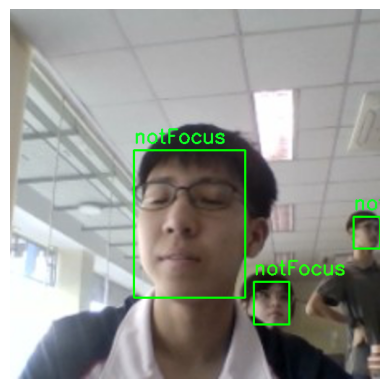

In [16]:
# Try it Out!!
show_box('dataset/notFocus/3.jpg')

In [17]:
# Walk through all the directories and files in the '/content/SPARKLE Dataset' directory
for (root, dir, files) in os.walk('dataset'):
    for file in files:
        # Process only image files (ignore text files which are already generated)
        if not file.endswith('txt'):
            # Get metadata for each image file, which includes face detection and YOLO annotation generation
            get_metadata(os.path.join(root, file))

In [18]:
# Define the root folder containing class subfolders and output directories for images and labels
root = Path('dataset')

# Output directories for images and labels
output_images = Path('val/images')
output_labels = Path('val/labels')

# Create output directories if they don't exist
output_images.mkdir(parents=True, exist_ok=True)
output_labels.mkdir(parents=True, exist_ok=True)

# Initialize a counter to track the number of files copied
file_count = 0

# Iterate over each class folder in the root directory
for class_folder in root.iterdir():
    if class_folder.is_dir():  # Check if it's a directory (class folder)
        for file in class_folder.iterdir():
            if file.suffix.lower() == '.jpg':  # Process image files
                dest = output_images / file.name  # Destination for image
            elif file.suffix.lower() == '.txt':  # Process text annotation files
                dest = output_labels / file.name  # Destination for text file
            else:
                continue  # Skip non-image and non-text files

            # Avoid overwriting files by renaming if the destination file already exists
            if dest.exists():
                new_name = f"{class_folder.name}_{file.name}"  # Append class folder name to avoid overwrite
                dest = dest.parent / new_name

            # Copy the file to the appropriate destination folder
            shutil.copy(file, dest)
            file_count += 1  # Increment the file counter

# Print a summary of the files copied
print(f"✅ Compiling complete. {file_count} files copied.")

✅ Compiling complete. 20 files copied.


In [19]:
# Load the pre-trained YOLO model with a custom checkpoint ('yolo11n.pt')
model = YOLO('yolo11n.pt')

# Train the model with specific settings
model.train(
    freeze=10,             # Freeze the first 10 layers during training to retain pre-trained features and reduce computational cost
    augment=True,          # Enable data augmentation to improve generalization (will apply default ultralytics data augmentation)
    data='data.yaml',  # Path to the dataset configuration file (data.yaml)
    epochs=30,             # Train the model for 30 epochs
    imgsz=512,             # Resize the images to 512x512 pixels during training
    patience=5            # Early stopping if validation loss doesn't improve (decrease in value) for 15 epochs
)

100%|██████████| 5.35M/5.35M [00:00<00:00, 66.4MB/s]


Ultralytics 8.3.154  Python-3.11.9 torch-2.2.2+cpu CPU (13th Gen Intel Core(TM) i9-13900K)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=10, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=Fa

100%|██████████| 755k/755k [00:00<00:00, 16.8MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.0.conv.weight'
Freezing layer 'model.0.bn.weight'
Freezing layer 'model.0.bn.bias'
Freezing layer 'model.1.conv.weight'
Freezing layer 'model.1.bn.weight'
Freezing layer 'model.1.bn.bias'
Freezing layer 'model.2.cv1.conv.weight'
Freezing layer 'model.2.cv1.bn.weight'
Freezing layer 'model.2.cv1.bn.bias'
Freezing layer 'model.2.cv2.conv.weight'
Freezing layer 'model.2.cv2.bn.weight'
Freezing layer 'model.2.cv2.bn.bias'
Freezing layer 'model.2.m.0.cv1.conv.weight'
Freezing layer 'model.2.m.0.cv1.bn.weight'
Freezing layer 'model.2.m.0.cv1.bn.bias'
Freezing layer 'model.2.m.0.cv2.conv.weight'
Freezing layer 'model.2.m.0.cv2.bn.weight'
Freezing layer 'model.2.m.0.cv2.bn.bias'
Freezing layer 'model.3.conv.weight'
Freezing layer 'model.3.bn.weight'
Freezing layer 'model.3.bn.bias'
Freezing layer 'model.4.cv1.conv.weight'
Freezing layer 'mo

FileNotFoundError: [34m[1mtrain: [0mError loading data from C:\Code_projects\BuildingBlocs\june2025ai\BBCSJune2025\train\images
See https://docs.ultralytics.com/datasets for dataset formatting guidance.

# Step 12: Perform inference on a set of images after training the model.

In [ ]:
# Load the trained YOLO model from the saved checkpoint
trained_pt = 'runs/detect/train3/weights/best.pt'
model = YOLO(trained_pt)

# Define the path to the images for inference
img_path = 'dataset/notFocus/27.jpg'

# Run inference on the specified image or directory
results = model(img_path, project='', save=True)


image 1/1 /content/SPARKLE Dataset/Zonglin/27.jpg: 512x512 1 Zonglin, 30.3ms
Speed: 2.8ms preprocess, 30.3ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /content/runs/output/predict7
